In [1]:
!pip install --upgrade pip
!pip install mediapipe==0.10.21 tensorflow==2.18.0 tensorflowjs==4.22.0 protobuf==4.25.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
INFO: pip is looking at multiple versions of ydf to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 103.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 105.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    U

In [1]:
import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os, shutil, random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import mediapipe as mp

random.seed(42028)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
PROJECT_DIR = "/content/drive/Shareddrives/OmniClick Team"
DATA_ROOT_DIR = os.path.join(PROJECT_DIR, "datasets")
COLUMBIA_DATA_DIR = os.path.join(DATA_ROOT_DIR, 'ColumbiaGazeProcessed')

COLUMBIA_BEST_MODEL_PATH = os.path.join(PROJECT_DIR, "notebooks/weights/mobilenetv2_gaze_columbia1_best.keras")
COLUMBIA_LAST_MODEL_PATH = os.path.join(PROJECT_DIR, "notebooks/weights/mobilenetv2_gaze_columbia1_last.keras")
COLUMBIA_TFJS_MODEL_PATH = os.path.join(PROJECT_DIR, "notebooks/weights/mobilenetv2_gaze_columbia1_tfjs")
COLUMBIA_TF_SAVE_MODEL_DIR = os.path.join(PROJECT_DIR, "notebooks/weights/mobilenetv2_columbia1_tf")

In [4]:
IMG_SIZE = (96, 96)
BATCH_SIZE = 16

COLUMBIA_LEFT_EYE_DIR = "/content/drive/Shareddrives/OmniClick Team/datasets/ColumbiaGaze_LeftEye"

columbia_train_dir = os.path.join(COLUMBIA_LEFT_EYE_DIR, 'train')
columbia_val_dir = os.path.join(COLUMBIA_LEFT_EYE_DIR, 'val')
columbia_test_dir = os.path.join(COLUMBIA_LEFT_EYE_DIR, 'test')

columbia_class_names = sorted(os.listdir(columbia_train_dir))
columbia_class_indices = {name: idx for idx, name in enumerate(columbia_class_names)}
NUM_CLASSES_COLUMBIA = len(columbia_class_names)

# For Columbia set class imbalance
columbia_y_train = []
for class_name in columbia_class_names:
    class_path = os.path.join(columbia_train_dir, class_name)
    columbia_y_train.extend([columbia_class_indices[class_name]] * len(os.listdir(class_path)))

# Compute weights
columbia_class_weights_array = compute_class_weight(class_weight='balanced', classes=np.unique(columbia_y_train), y=columbia_y_train)
columbia_class_weights = dict(enumerate(columbia_class_weights_array))

center_index = columbia_class_indices['center']
columbia_class_weights[center_index] *= 1.5

# Data Aug for Columbia set
columbia_train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    brightness_range=[0.7, 1.3],
    zoom_range=0.1,
    horizontal_flip=True
).flow_from_directory(
    columbia_train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
columbia_val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    columbia_val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
columbia_test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    columbia_test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Checkpoints
callbacks = [
    ModelCheckpoint(
        COLUMBIA_BEST_MODEL_PATH,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    ModelCheckpoint(
        COLUMBIA_LAST_MODEL_PATH,
        save_best_only=False,
        save_weights_only=False,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=25,
        restore_best_weights=True
    )
]

Found 1129 images belonging to 9 classes.
Found 262 images belonging to 9 classes.
Found 258 images belonging to 9 classes.


In [5]:
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(NUM_CLASSES_COLUMBIA, activation='softmax')(x)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
optimizer = tf.keras.optimizers.AdamW(learning_rate=3e-4, weight_decay=1e-5)
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
# Train
history = model.fit(
    columbia_train_gen,
    validation_data=columbia_val_gen,
    epochs=100,
    callbacks=callbacks
)
model.export(COLUMBIA_TF_SAVE_MODEL_DIR)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.1651 - loss: 2.3562
Epoch 1: val_loss improved from inf to 2.23131, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia1_best.keras

Epoch 1: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia1_last.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 689s 9s/step - accuracy: 0.1655 - loss: 2.3544 - val_accuracy: 0.1832 - val_loss: 2.2313
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - accuracy: 0.3286 - loss: 1.8124
Epoch 2: val_loss improved from 2.23131 to 2.18724, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia1_best.keras

Epoch 2: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia1_last.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 52s 734ms/step - accuracy: 0.3287 - loss: 1.8120 - val_accuracy: 0.1870 - val_loss: 2.1872
Epoch 3/100
71/

In [10]:
!tensorflowjs_converter --input_format=tf_saved_model $COLUMBIA_TF_SAVE_MODEL_DIR $COLUMBIA_TFJS_MODEL_DIR

2025-05-27 11:21:17.478522: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748344877.535149   22222 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748344877.552121   22222 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
Traceback (most recent call last):
  File "/usr/local/bin/tensorflowjs_converter", line 8, in <module>
    sys.exit(pip_main())
             ^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/tensorflowjs/converters/converter.py", line 959, in pip_main
    main([' '.join(sys.argv[1:])])
  File "/usr/local/lib

In [11]:
# Evaluate
test_loss, test_acc = model.evaluate(columbia_test_gen)
print(f"Test Accuracy: {test_acc:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 142s 9s/step - accuracy: 0.4771 - loss: 2.6370
Test Accuracy: 0.5698


In [12]:
best_model = tf.keras.models.load_model(COLUMBIA_BEST_MODEL_PATH)
last_model = tf.keras.models.load_model(COLUMBIA_LAST_MODEL_PATH)

In [13]:
model = best_model

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255).flow_from_directory(
    os.path.join(COLUMBIA_DATA_DIR, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Predict
y_pred_probs = model.predict(columbia_test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = columbia_test_gen.classes
class_names = list(columbia_test_gen.class_indices.keys())

Found 883 images belonging to 9 classes.
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 216ms/step


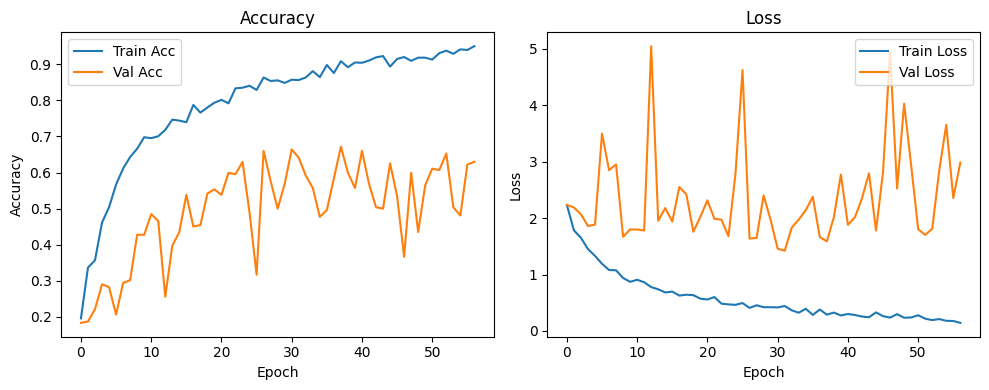

In [14]:
# 1. Plot training curves
def plot_training_curves(history):
    plt.figure(figsize=(10, 4))
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_training_curves(history)

In [16]:
# 2. Classification report
report = classification_report(y_true, y_pred, target_names=columbia_class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,precision,recall,f1-score,support
center,0.000000,0.000000,0.000000,9.000000
down,0.000000,0.000000,0.000000,14.000000
down_left,0.479167,0.718750,0.575000,32.000000
down_right,0.578947,0.478261,0.523810,23.000000
left,0.578947,0.717391,0.640777,46.000000
right,0.625000,0.609756,0.617284,41.000000
up,0.066667,0.090909,0.076923,11.000000
up_left,0.622222,0.736842,0.674699,38.000000
up_right,0.838710,0.590909,0.693333,44.000000
accuracy,0.569767,0.569767,0.569767,0.569767


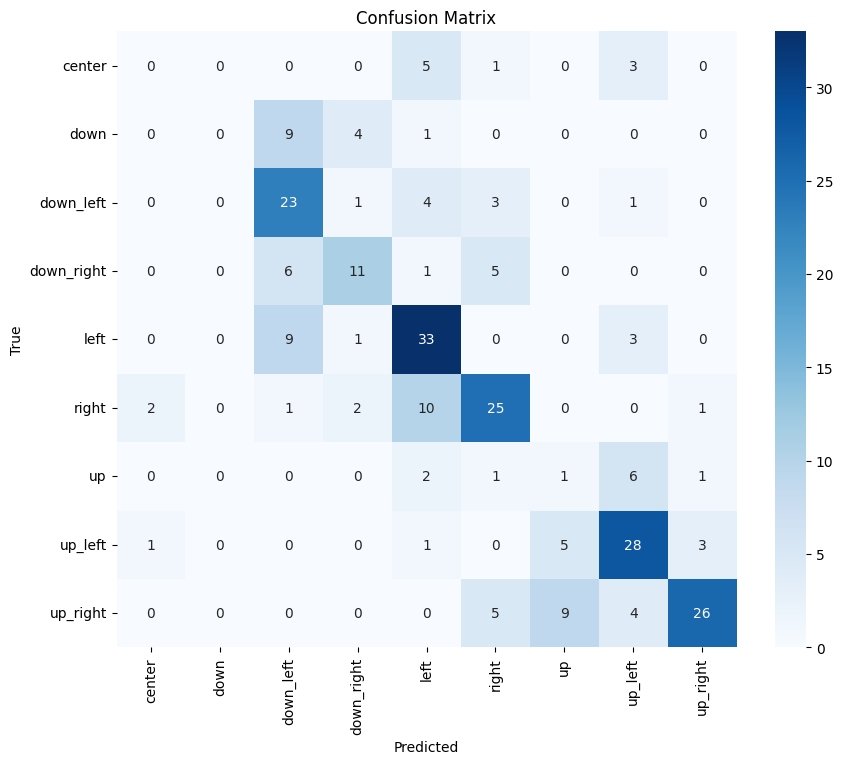

In [17]:
# 3. Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


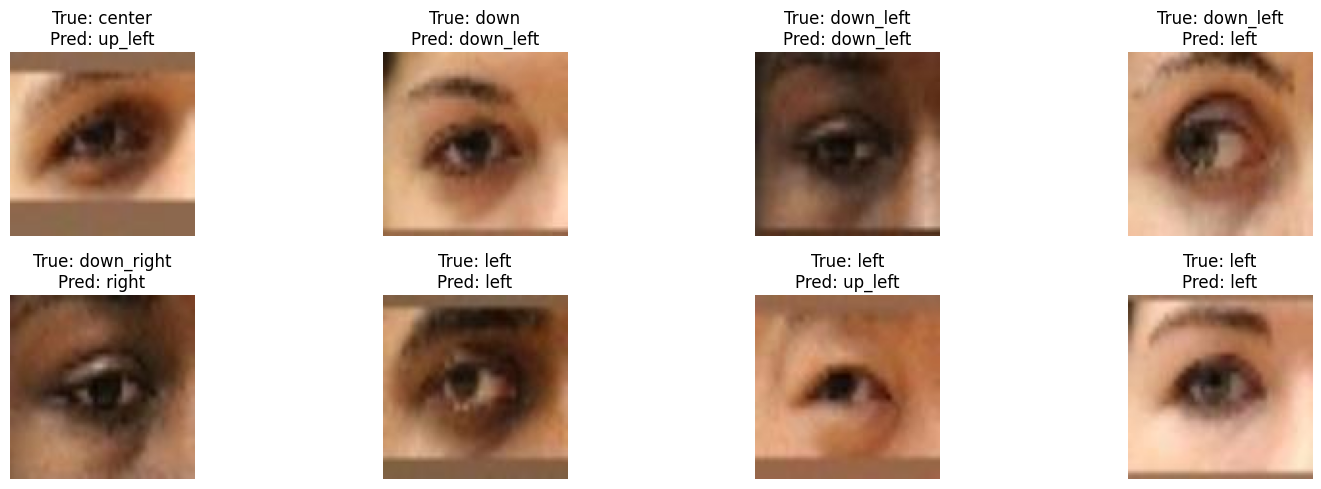

In [19]:
# 4. Inference examples
def plot_inference_examples(generator, y_pred, class_names, num_examples=8):
    fig, axes = plt.subplots(2, num_examples // 2, figsize=(16, 5))
    axes = axes.flatten()
    for i in range(num_examples):
        img, label = generator[i]
        pred_label = class_names[np.argmax(model.predict(np.expand_dims(img[0], axis=0)))]
        true_label = class_names[np.argmax(label[0])]
        axes[i].imshow(img[0])
        axes[i].set_title(f"True: {true_label}\nPred: {pred_label}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Display
plot_inference_examples(columbia_test_gen, y_pred, class_names)